### Naive Bayes Classifier Task
### 문장에서 느껴지는 감정 예측
##### 다중 분류(Multiclass Classification)
- 비대면 심리 상담사로서 메세지를 전달한 환자에 대한 감정 데이터를 수집했다.
- 각 메세지 별로 감정이 표시되어 있다.
- 미래에 동일한 메세지를 보내는 환자에게 어떤 심리 치료가 적합할 수 있는지 알아보기 위한 모델을 구축한다

In [1]:
import pandas as pd

path = './datasets/feeling.csv'
f_df = pd.read_csv(path)
# f_df = pd.read_csv(path, sep = ';')
f_df

,message;feeling
0,im feeling quite sad and sorry for myself but ...
1,i feel like i am still looking at a blank canv...
2,i feel like a faithful servant;love
3,i am just feeling cranky and blue;anger
4,i can have for a treat or if i am feeling fest...
...,...
17995,i just had a very brief time in the beanbag an...
17996,i am now turning and i feel pathetic that i am...
17997,i feel strong and good overall;joy
17998,i feel like this was such a rude comment and i...


In [2]:
# 데이터 복사
f_need_df = f_df.copy()

In [3]:
# message ; feeling 으로 되어있기 떄문에 ; 기준으로 데이터 셋 분리
f_need_df['message'] = f_need_df['message;feeling'].apply(lambda x: x.split(';')[0])
f_need_df['feeling'] = f_need_df['message;feeling'].apply(lambda x: x.split(';')[1])
f_need_df = f_need_df.drop(labels='message;feeling', axis =1).reset_index(drop=True)
f_need_df


,message,feeling
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy
...,...,...
17995,i just had a very brief time in the beanbag an...,sadness
17996,i am now turning and i feel pathetic that i am...,sadness
17997,i feel strong and good overall,joy
17998,i feel like this was such a rude comment and i...,anger


In [4]:
# 데이터 정보 확인
f_need_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  18000 non-null  object
 1   feeling  18000 non-null  object
dtypes: object(2)
memory usage: 281.4+ KB


In [5]:
# Targets 의 값에 대하여 LabelEncoder 를 사용하여 범주형 데이터로 변환
from sklearn.preprocessing import LabelEncoder

feeling_encoder = LabelEncoder()
targets = feeling_encoder.fit_transform(f_need_df.loc[:, 'feeling'])
f_need_df['Targets'] = targets


In [6]:
f_need_df

,message,feeling,Targets
0,im feeling quite sad and sorry for myself but ...,sadness,4
1,i feel like i am still looking at a blank canv...,sadness,4
2,i feel like a faithful servant,love,3
3,i am just feeling cranky and blue,anger,0
4,i can have for a treat or if i am feeling festive,joy,2
...,...,...,...
17995,i just had a very brief time in the beanbag an...,sadness,4
17996,i am now turning and i feel pathetic that i am...,sadness,4
17997,i feel strong and good overall,joy,2
17998,i feel like this was such a rude comment and i...,anger,0


In [7]:
# 불균형
f_need_df['Targets'].value_counts()

Targets
2    6066
4    5216
0    2434
1    2149
3    1482
5     653
Name: count, dtype: int64

In [8]:
# Labelencoer 를 사용 후 각각의 범주형 값에 대하여 어떤 value 값이였는지 확인 
label_dict = dict(zip(feeling_encoder.transform(feeling_encoder.classes_), feeling_encoder.classes_))
print(label_dict)

{0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}


In [9]:
# 불필요 feature drop
f_need_df = f_need_df.drop(labels='feeling', axis =1)

In [10]:
f_need_df

,message,Targets
0,im feeling quite sad and sorry for myself but ...,4
1,i feel like i am still looking at a blank canv...,4
2,i feel like a faithful servant,3
3,i am just feeling cranky and blue,0
4,i can have for a treat or if i am feeling festive,2
...,...,...
17995,i just had a very brief time in the beanbag an...,4
17996,i am now turning and i feel pathetic that i am...,4
17997,i feel strong and good overall,2
17998,i feel like this was such a rude comment and i...,0


In [11]:
f_need_df.drop_duplicates(inplace=True)

In [12]:
f_need_df.duplicated().sum()

0

In [13]:
# 데이터 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
train_test_split(f_need_df.message, f_need_df.Targets, stratify=f_need_df.Targets, test_size=0.2, random_state=124)

In [14]:
# CountVenctorizer 를 이용해 각 문장에 대하여 target의 값이 포함되어 있는지 전체 변환 확인
# 시각화를 위해서 표기
# from sklearn.feature_extraction.text import CountVectorizer

# c_vct = CountVectorizer()
# freq = c_vct.fit_transform(f_need_df.message)
# print(freq.toarray())
# print(c_vct.vocabulary_)

In [15]:
# CountVectorizer 와 MulinomialNB 를 파이프라인으로 구축하여 매번 분석 시 반복된 훈련을 피하는 용도
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# PipeLline 안에는 리스트로 담는다 ('key':객체)
# 매번 작업 시, Vectorizer를 사용해야 하지만, 
# 파이프라인으로 구축 시 직접 할 필요 없다.
m_nb_pipe = Pipeline([('count_vectorizer', CountVectorizer()), ('multinomial_NB', MultinomialNB())])

# 훈련 데이터 전달
m_nb_pipe.fit(X_train, y_train)

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('multinomial_NB', MultinomialNB())])

In [16]:
# 테스트 데이터 훈련
prediction = m_nb_pipe.predict(X_test)

In [17]:
# 내가 입력한 데이터에 대하여 테스트 진행
# m_nb_pipe.predict(['i love you'])
print(y_test)
print(m_nb_pipe.predict(X_test))

14477    4
2660     2
14567    0
3658     2
662      3
        ..
15218    0
8734     4
11995    1
16625    2
7963     4
Name: Targets, Length: 3600, dtype: int32
[4 2 4 ... 4 2 4]


In [18]:
# 테스트 데이터에 대하여 정확도 확인
m_nb_pipe.score(X_test, y_test)

0.7519444444444444

In [19]:
feeling_encoder.classes_[m_nb_pipe.predict(X_test)]

array(['sadness', 'joy', 'sadness', ..., 'sadness', 'joy', 'sadness'],
      dtype=object)

In [20]:
# 실제 내가 입력한 데이터에 대하여 나온 인덱스 번호아 어떤 Targets 을 가지고 있는지 확인
label_dict = dict(zip(feeling_encoder.transform(feeling_encoder.classes_), feeling_encoder.classes_))
print(label_dict)

{0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# 타겟 데이터와 예측 객체를 전달받는다.
# 정밀도, 재현율, F1 score는 다중 분류에서 각각의 확률값의 평균을 구해서 나타내야 한다.
# 이 때, macro 방식과, micro 방식이 대표적이다.
# macro: 평균을 낸 뒤, 그 평균의 다시 평균을 구하는 방식 (샘플 수는 신경쓰지 않는다).
# micro: 샘플 수를 전체 합하고 전체 개수도 전체 합해서 나눠주는 방식(샘플 수를 신경쓴다).
# 카겟 데이터의 비중이 많이 차이난다면, micro방식을 사용하는것이 바람직하다.
def get_evaluation(y_test, prediction, classifier=None, X_test=None):
#     오차 행렬
    confusion = confusion_matrix(y_test, prediction)
#     정확도
    accuracy = accuracy_score(y_test , prediction)
#     정밀도
    precision = precision_score(y_test , prediction, average='micro')
#     재현율
    recall = recall_score(y_test , prediction, average='micro')
#     F1 score
    f1 = f1_score(y_test, prediction, average='micro')


    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, , F1: {3:.4f},'.format(accuracy, precision, recall, f1))
    print("#" * 80)
    
    if classifier is not None and  X_test is not None:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
        titles_options = [("Confusion matrix", None), ("Normalized confusion matrix", "true")]

        for (title, normalize), ax in zip(titles_options, axes.flatten()):
            disp = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, ax=ax, cmap=plt.cm.Blues, normalize=normalize)
            disp.ax_.set_title(title)
        plt.show()

In [22]:
prediction = m_nb_pipe.predict(X_test)

오차 행렬
[[ 287    5   74    1  120    0]
 [  18  224   81    1  106    0]
 [   4    2 1146    6   55    0]
 [   5    3  168   72   48    0]
 [   7    3   62    1  970    0]
 [   2   16   68    0   37    8]]
정확도: 0.7519, 정밀도: 0.7519, 재현율: 0.7519, , F1: 0.7519,
################################################################################


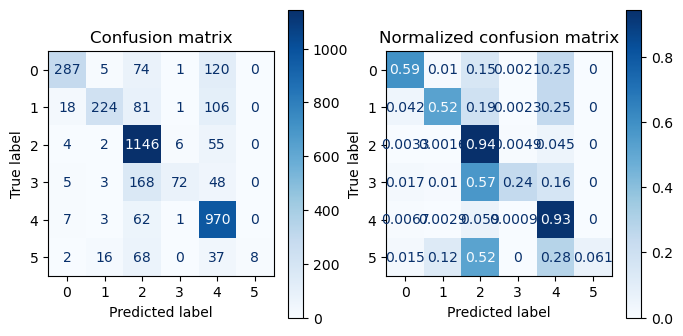

In [23]:
get_evaluation(y_test, prediction, m_nb_pipe, X_test)

#### 정리 
위의 오차 행렬을 보면, 3과, 5에 대한 예측률이 좋지 않다. 이는 타켓 데이터의 불균형 문제로 판단된다.  
언더 샘플링을 통해 타켓 데이터의 비중을 맞춰주면 T<sub>n</sub>이 높아질 것으로 보인다.

# 언더샘플링

In [24]:
import pandas as pd

path = './datasets/feeling.csv'
# f_df = pd.read_csv(path)
f_df = pd.read_csv(path, sep = ';')
f_df

,message,feeling
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy
...,...,...
17995,i just had a very brief time in the beanbag an...,sadness
17996,i am now turning and i feel pathetic that i am...,sadness
17997,i feel strong and good overall,joy
17998,i feel like this was such a rude comment and i...,anger


In [25]:
# 'anger', 'fear', 'joy', 'love', 'sadneed', 'surprise'
anger = f_need_df[f_need_df.Targets == 0].sample(653, random_state=124)
fear = f_need_df[f_need_df.Targets == 1].sample(653, random_state=124)
joy = f_need_df[f_need_df.Targets == 2].sample(653, random_state =124)
love = f_need_df[f_need_df.Targets == 3].sample(653, random_state =124)
sadness = f_need_df[f_need_df.Targets == 4].sample(653, random_state =124)
surprise = f_need_df[f_need_df.Targets == 5]


under_f_df = pd.concat([anger, fear, joy, love, sadness, surprise]).reset_index(drop=True)

In [26]:
under_f_df.Targets.value_counts()

Targets
0    653
1    653
2    653
3    653
4    653
5    653
Name: count, dtype: int64

In [27]:
# 데이터 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
train_test_split(under_f_df.message, under_f_df.Targets, stratify=under_f_df.Targets, test_size=0.2, random_state=124)

In [28]:
# CountVectorizer 와 MulinomialNB 를 파이프라인으로 구축하여 매번 분석 시 반복된 훈련을 피하는 용도
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# PipeLline 안에는 리스트로 담는다 ('key':객체)
# 매번 작업 시, Vectorizer를 사용해야 하지만, 
# 파이프라인으로 구축 시 직접 할 필요 없다.
m_nb_pipe = Pipeline([('count_vectorizer', CountVectorizer()), ('multinomial_NB', MultinomialNB())])

# 훈련 데이터 전달
m_nb_pipe.fit(X_train, y_train)

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('multinomial_NB', MultinomialNB())])

In [29]:
# 테스트 데이터 훈련
prediction = m_nb_pipe.predict(X_test)

In [30]:
# 내가 입력한 데이터에 대하여 테스트 진행
# m_nb_pipe.predict(['i love you'])
print(y_test)
print(m_nb_pipe.predict(X_test))

3589    5
655     1
1814    2
4       0
3813    5
       ..
393     0
1957    2
1292    1
2054    3
1015    1
Name: Targets, Length: 784, dtype: int32
[5 5 2 0 5 5 4 1 3 1 2 2 2 3 1 1 0 1 4 0 5 0 3 5 4 4 2 3 1 5 2 4 2 5 2 3 3
 1 5 1 3 2 0 4 3 4 3 5 2 3 4 5 4 3 0 5 1 4 1 4 3 4 3 3 5 3 4 2 3 4 2 2 0 5
 2 0 0 1 1 4 4 2 2 4 1 3 0 1 5 5 0 5 3 3 2 2 0 1 2 5 2 3 1 1 3 4 4 3 4 3 4
 0 5 1 2 0 0 5 3 5 2 2 5 2 0 2 3 3 2 2 3 0 1 3 4 5 0 0 0 0 0 0 2 1 1 2 0 0
 2 4 2 2 5 2 3 4 1 1 3 1 5 4 0 1 5 2 2 3 1 0 3 2 1 1 3 1 1 2 4 1 1 1 5 5 3
 1 4 5 4 3 5 3 3 3 1 5 5 1 2 5 5 2 3 5 3 0 1 2 2 3 5 3 2 4 2 3 3 0 1 4 5 1
 4 5 3 2 0 3 0 0 5 0 1 1 5 1 3 5 1 5 3 1 5 1 0 0 1 5 2 4 4 1 4 5 2 0 2 0 0
 1 0 2 0 3 5 2 5 4 4 3 2 5 5 3 5 0 1 2 1 3 0 0 2 1 0 3 3 1 5 0 5 1 0 4 5 0
 3 4 1 1 0 4 3 2 0 5 5 5 3 2 0 2 1 0 5 3 2 1 5 3 5 3 0 0 5 2 2 4 0 5 5 5 0
 3 5 2 2 5 5 2 1 5 4 1 5 1 5 5 0 4 5 0 3 3 2 4 5 5 5 3 3 3 2 2 5 2 0 1 5 2
 1 0 5 2 5 3 5 4 3 1 5 4 5 5 0 1 3 5 0 4 2 4 0 5 5 3 4 1 0 2 3 3 0 3 5 5 1
 0 5 4 2 5 5 1 0 5 2 0 4

In [31]:
# 언더샘플링 이후 데이터에 대하여 정확도 확인
m_nb_pipe.score(X_test, y_test)

0.7104591836734694

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# 정밀도, 재현율, F1 score는 다중 분류에서 각각의 확률값의 평균을 구해서 나타내야 한다.
# 이 때, macro 방식과, micro 방식이 대표적이다.
# macro: 평균을 낸 뒤, 그 평균의 다시 평균을 구하는 방식(샘플 수는 신경쓰지 않는다).
# micro: 샘플 수를 전체 합하고 전체 개수도 전체 합해서 나눠주는 방식(샘플 수를 신경쓴다).
# 타겟 데이터의 비중이 많이 차이난다면, micro방식을 사용하는 것이 바람직하다.
def get_evaluation(y_test, prediction, classifier=None, X_test=None):
#     오차 행렬
    confusion = confusion_matrix(y_test, prediction)
#     정확도
    accuracy = accuracy_score(y_test , prediction)
#     정밀도
    precision = precision_score(y_test , prediction, average='macro')
#     재현율
    recall = recall_score(y_test , prediction, average='macro')
#     F1 score
    f1 = f1_score(y_test, prediction, average='macro')
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
    print("#" * 80)
    
    if classifier is not None and  X_test is not None:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
        titles_options = [("Confusion matrix", None), ("Normalized confusion matrix", "true")]

        for (title, normalize), ax in zip(titles_options, axes.flatten()):
            disp = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, ax=ax, cmap=plt.cm.Blues, normalize=normalize)
            disp.ax_.set_title(title)
        plt.show()

In [33]:
prediction = m_nb_pipe.predict(X_test)

오차 행렬
[[ 93   8   7   0  11  11]
 [  8  92   8   5   3  15]
 [  4   8  89  16   4  10]
 [  3   5  18 101   0   4]
 [ 12  12   9  11  73  14]
 [  1   5   6   6   3 109]]
정확도: 0.7105, 정밀도: 0.7163, 재현율: 0.7106, F1: 0.7085
################################################################################


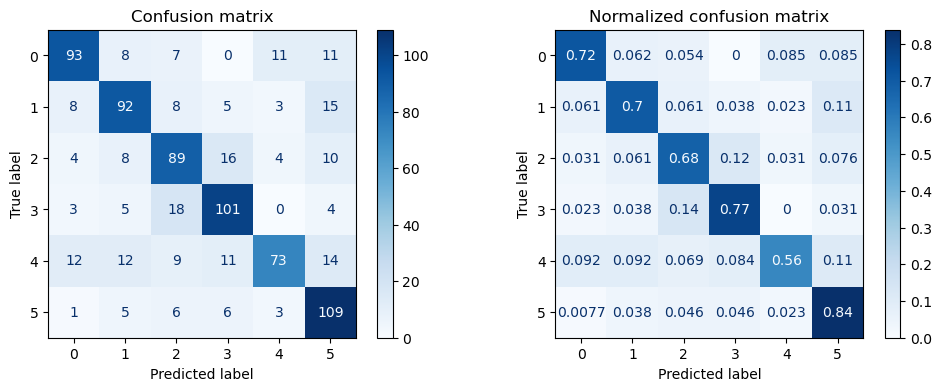

In [34]:
get_evaluation(y_test, prediction, m_nb_pipe, X_test)